In [47]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
# Data set Load
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')


In [49]:
# Checking for null value
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [50]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [51]:
# checking for duplicate values
print(movies.duplicated().sum())
print(ratings.duplicated().sum())

0
0


In [52]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [53]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [54]:
# Function to create mappings between IDs and their encoded values
def create_id_mappings(ids):
    # Dictionary mapping original IDs to encoded values
    id2encoded = {x: i for i, x in enumerate(ids)}
    # Dictionary mapping encoded values back to original IDs
    encoded2id = {i: x for i, x in enumerate(ids)}
    return id2encoded, encoded2id


In [55]:
# Get unique user IDs and movie IDs from the ratings dataset
user_ids = ratings["userId"].unique().tolist()
movie_ids = ratings["movieId"].unique().tolist()


In [56]:

user2user_encoded, userencoded2user = create_id_mappings(user_ids)


In [57]:


movie2movie_encoded, movie_encoded2movie = create_id_mappings(movie_ids)


In [58]:

# Map user IDs to their encoded values in the ratings DataFrame
ratings["user"] = ratings["userId"].map(user2user_encoded)

# Map movie IDs to their encoded values in the ratings DataFrame
ratings["movie"] = ratings["movieId"].map(movie2movie_encoded)

# Convert ratings to float32 for compatibility with the model
ratings["rating"] = ratings["rating"].values.astype(np.float32)


In [59]:

# Split the ratings data into training and testing sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)


In [60]:

# Calculate the number of unique users and movies after encoding
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)


In [61]:
ratings.head(5)

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [62]:
embedding_size = 50
# This specifies the dimensionality of the embedding vectors for both users and movies.
# Each user and movie will be represented as a dense vector of 50 dimensions.


In [63]:

user_input = Input(shape=(1,))
user_embedding = Embedding(num_users, embedding_size)(user_input)
# This creates an embedding layer for users.
# It maps each user ID (from 0 to num_users-1) to a dense vector of embedding_size (50 in this case).
user_vector = Flatten()(user_embedding)
# This flattens the user embedding vector into a 1-dimensional vector.
# It prepares the data for further processing.


In [64]:

movie_input = Input(shape=(1,))
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)
movie_vector = Flatten()(movie_embedding)


In [65]:
dot_product = Dot(axes=1)([user_vector, movie_vector])
#The Dot layer in Keras computes the dot product between two tensors.
# In this case, it computes the dot product between the user_vector and movie_vector tensors.


In [66]:

model = Model(inputs=[user_input, movie_input], outputs=dot_product)
#The Model class in Keras allows you to define a neural network model by specifying its inputs and outputs.


In [67]:
model.compile(optimizer='adam', loss='mean_squared_error')
# Compilation: Configures the model for training with an optimizer and a loss function.
# The 'adam' optimizer refers to the Adam (Adaptive Moment Estimation) optimizer.

In [68]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=10,               # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


In [85]:
history = model.fit(
    [train.user, train.movie],  # Training data: user IDs and movie IDs
    train.rating,                # Training labels: ratings
    epochs=100,                  # Number of epochs (iterations over the entire datase5t)
    verbose=1,                   # Verbosity mode (1: progress bar, 0: silent)
    validation_data=([test.user, test.movie], test.rating),  # Validation data for evaluation during training
    callbacks=[early_stopping] 
)

Epoch 1/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4522 - val_loss: 1.2639
Epoch 2/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3591 - val_loss: 1.2714
Epoch 3/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2969 - val_loss: 1.2827
Epoch 4/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2470 - val_loss: 1.2917
Epoch 5/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2018 - val_loss: 1.3068
Epoch 6/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1645 - val_loss: 1.3272
Epoch 7/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1400 - val_loss: 1.3397
Epoch 8/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1173 - val_loss: 1.3622
Epoch 9/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1026 - val_loss: 1.3754
Epoch 10/100
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0892 - val_loss: 1.3886


### Loss:- 
 - (also known as training loss or training error) is a measure of how well the model is predicting the target variable (ratings) on the training data during each epoch of training.

### Validation Loss:-
 - it (validation error) is similar to the loss, but it is calculated on a separate validation dataset.

In [70]:
# Specify the user ID for whom we want to recommend movies
user_id = 95
# Filter the ratings dataset to get movies watched by the user
movies_watched_by_user = ratings[ratings.userId == user_id]


In [71]:

# Find movies that the user has not watched
movies_not_watched = movies[~movies["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]


In [72]:
# Convert to a set to find unique movie IDs not watched by the user
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))


In [73]:
# Map movie IDs to encoded movie IDs using movie2movie_encoded dictionary
movies_not_watched = [movie2movie_encoded.get(x) for x in movies_not_watched]



In [74]:
# Get the encoded user ID for user_id
user_encoder = user2user_encoded.get(user_id)


In [75]:
# Create a 2D numpy array where each row contains [encoded_user_id, movie_id]
user_movie_array = np.array([[user_encoder, movie] for movie in movies_not_watched])


In [76]:
# Extract the encoded user IDs into user_input_array
user_input_array = user_movie_array[:, 0]


In [77]:

# Extract the movie IDs into movie_input_array
movie_input_array = user_movie_array[:, 1]


In [78]:
# Predict ratings for the user on the movies not watched
ratingss = model.predict([user_input_array, movie_input_array]).flatten()


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [79]:
# Get indices of the top 10 ratings in descending order
top_ratings_indices = ratingss.argsort()[-10:][::-1]


In [80]:
# Retrieve movie titles for recommended movie IDs
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x]) for x in top_ratings_indices]


In [81]:

# Print user ID for whom recommendations are being shown
print(f"Showing recommendations for user: {user_id}")



Showing recommendations for user: 95


In [82]:
print("-" * 36)
# Print movies with high ratings from the user's watched history
print("Movies with high ratings from user")
print("-" * 32)
# Get top 5 movies watched by the user based on highest ratings
top_movies_user = movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values
# Filter movie details for the top rated movies
movie_df_rows = movies[movies["movieId"].isin(top_movies_user)]
# Print details of top rated movies
for row in movie_df_rows.itertuples():
    print(f"{row.title} : {row.genres}")


------------------------------------
Movies with high ratings from user
--------------------------------
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Delicatessen (1991) : Comedy|Drama|Romance
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Godfather: Part II, The (1974) : Crime|Drama
Drugstore Cowboy (1989) : Crime|Drama


In [83]:

# Print top 10 movie recommendations
print("-" * 32)
print("Top 10 movie recommendations")
print("-" * 32)
# Filter movie details for the recommended movie IDs
recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
# Print details of recommended movies
for row in recommended_movies.itertuples():
    print(f"{row.title} : {row.genres}")


--------------------------------
Top 10 movie recommendations
--------------------------------
Shall We Dance (1937) : Comedy|Musical|Romance
Harold and Maude (1971) : Comedy|Drama|Romance
Lifeboat (1944) : Drama|War
Drunken Master (Jui kuen) (1978) : Action|Comedy
Shane (1953) : Drama|Western
Moby Dick (1956) : Drama
Phantom of the Paradise (1974) : Comedy|Fantasy|Horror|Musical|Thriller
Hunger (2008) : Drama
Submarine (2010) : Comedy|Drama|Romance
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


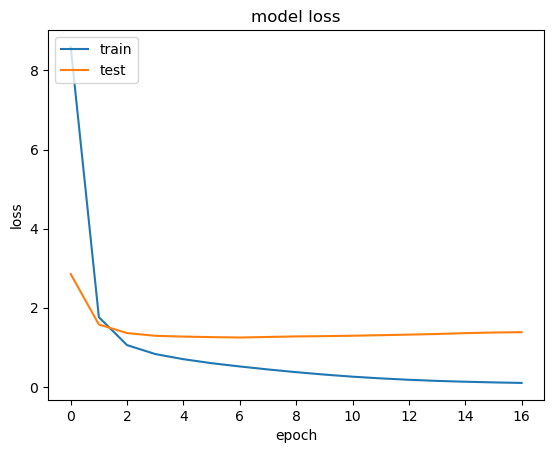

In [84]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()